In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
from sklearn import datasets
import tensorflow as tf

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

2022-11-16 18:20:25.945437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 18:20:25.945497: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Classical data

In [2]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.label = label
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, self.label

In [3]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="optdigits.tra", transform=transform, label = 0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for element in dataloader:
   print(element)

[tensor([[[[0.0000, 0.0000, 0.0000, 0.7500, 0.9375, 0.2500, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4375, 0.5625, 0.5000, 0.9375, 0.0000, 0.0000],
          [0.0000, 0.1250, 0.7500, 0.0000, 0.0000, 0.5625, 0.2500, 0.0000],
          [0.0000, 0.3125, 0.6875, 0.0000, 0.0000, 0.2500, 0.5000, 0.0000],
          [0.0000, 0.5000, 0.2500, 0.0000, 0.0000, 0.5000, 0.3750, 0.0000],
          [0.0000, 0.1250, 0.7500, 0.0000, 0.0625, 0.8750, 0.3125, 0.0000],
          [0.0000, 0.0000, 0.8125, 0.9375, 1.0000, 0.7500, 0.0625, 0.0000],
          [0.0000, 0.0000, 0.1250, 0.6250, 0.7500, 0.0625, 0.0000, 0.0000]]]]), tensor([0])]
[tensor([[[[0.0000, 0.0000, 0.0000, 0.6250, 0.7500, 0.1250, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.6875, 1.0000, 1.0000, 0.6250, 0.0000, 0.0000],
          [0.0000, 0.1875, 1.0000, 0.3125, 0.3750, 0.7500, 0.1250, 0.0000],
          [0.0000, 0.3125, 0.7500, 0.0000, 0.0000, 0.3750, 0.5000, 0.0000],
          [0.0000, 0.2500, 1.0000, 0.0000, 0.0000, 0.3750, 0.5000, 0.

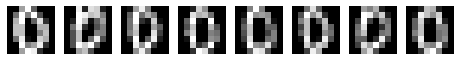

In [4]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')
    
plt.show()

In [5]:
# Load the digits dataset
digits = datasets.load_digits()

x_train = digits.data
y_train = digits.target

x_train = x_train.reshape(len(x_train), 8, 8)
x_train.shape

(1797, 8, 8)

In [6]:
def resize_data(x, y, label, image_size):

    arr = []

    for t, l in zip(x, y):
        if l in label:
            t = torch.tensor(t, dtype = torch.float32).reshape(image_size, image_size)
            t = t/16
            arr.append((t, l))
    return arr

rd = resize_data(x_train, y_train, label = (0, ), image_size = 8)
rd

[(tensor([[0.0000, 0.0000, 0.3125, 0.8125, 0.5625, 0.0625, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.8125, 0.9375, 0.6250, 0.9375, 0.3125, 0.0000],
          [0.0000, 0.1875, 0.9375, 0.1250, 0.0000, 0.6875, 0.5000, 0.0000],
          [0.0000, 0.2500, 0.7500, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
          [0.0000, 0.3125, 0.5000, 0.0000, 0.0000, 0.5625, 0.5000, 0.0000],
          [0.0000, 0.2500, 0.6875, 0.0000, 0.0625, 0.7500, 0.4375, 0.0000],
          [0.0000, 0.1250, 0.8750, 0.3125, 0.6250, 0.7500, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3750, 0.8125, 0.6250, 0.0000, 0.0000, 0.0000]]),
  0),
 (tensor([[0.0000, 0.0000, 0.0625, 0.5625, 0.9375, 0.6875, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.6875, 1.0000, 0.5000, 0.8750, 0.3750, 0.0000],
          [0.0000, 0.1250, 1.0000, 0.6250, 0.0000, 0.5625, 0.5625, 0.0000],
          [0.0000, 0.0625, 1.0000, 0.2500, 0.0000, 0.5000, 0.5000, 0.0000],
          [0.0000, 0.2500, 1.0000, 0.2500, 0.0000, 0.5000, 0.5000, 0.0000],
    

In [7]:
dataloader1 = torch.utils.data.DataLoader(rd, batch_size=batch_size, shuffle=True, drop_last=True)

for element in dataloader1:
   print(element)

[tensor([[[0.0000, 0.0000, 0.4375, 1.0000, 0.9375, 0.0625, 0.0000, 0.0000],
         [0.0000, 0.3125, 1.0000, 0.8125, 1.0000, 0.5000, 0.0000, 0.0000],
         [0.0000, 0.5625, 0.6875, 0.0000, 0.2500, 1.0000, 0.2500, 0.0000],
         [0.0000, 0.7500, 0.5000, 0.0000, 0.0000, 0.6875, 0.6875, 0.0000],
         [0.0000, 0.6875, 0.5000, 0.0000, 0.0000, 0.5000, 0.7500, 0.0000],
         [0.0000, 0.5000, 0.8125, 0.0000, 0.0000, 0.7500, 0.6250, 0.0000],
         [0.0000, 0.1250, 1.0000, 0.5625, 0.7500, 0.9375, 0.1875, 0.0000],
         [0.0000, 0.0000, 0.5000, 1.0000, 0.8125, 0.3125, 0.0000, 0.0000]]]), tensor([0])]
[tensor([[[0.0000, 0.0000, 0.2500, 1.0000, 0.7500, 0.0625, 0.0000, 0.0000],
         [0.0000, 0.1250, 1.0000, 1.0000, 0.6875, 0.5000, 0.0000, 0.0000],
         [0.0000, 0.1875, 1.0000, 0.8125, 0.0625, 0.8750, 0.1250, 0.0000],
         [0.0000, 0.2500, 1.0000, 0.0000, 0.0000, 0.8125, 0.2500, 0.0000],
         [0.0000, 0.2500, 0.9375, 0.0000, 0.0000, 0.8125, 0.5000, 0.0000],
       

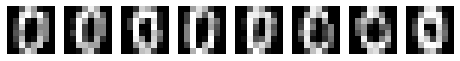

In [8]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = rd[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')
    
plt.show() 

### Quantum Generator

In [9]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
ancillary_qubits = 1  # Number of ancillary qubits / N_A
gen_n_layers = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G
image_size = 8

In [10]:
# Quantum simulator
dev = qml.device("default.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_generator_circuit(noise, gen_weights):

    gen_weights = gen_weights.reshape(gen_n_layers, n_qubits)

    # Encoding layer
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # PQC layers
    for i in range(gen_n_layers):

        # Rotation gates
        for y in range(n_qubits):
            qml.RY(gen_weights[i][y], wires=y)

        # Entangling gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    # Returning probability of each computational basis state
    return qml.probs(wires=list(range(n_qubits)))

In [12]:
# Testing generator circuit

noise = torch.rand(n_qubits, device=device) * math.pi / 2
gen_weights = torch.rand(gen_n_layers, n_qubits, device=device) * math.pi / 2

qgc = quantum_generator_circuit(noise, gen_weights)
qgc 

tensor([1.9261e-03, 7.3837e-04, 1.1011e-01, 6.4698e-02, 1.0286e-05, 1.7982e-01,
        5.7609e-04, 5.5867e-03, 1.8268e-03, 7.2636e-06, 8.4063e-02, 2.1729e-02,
        3.3501e-03, 8.1852e-03, 4.6617e-04, 5.6530e-04, 1.1282e-04, 1.3895e-03,
        1.5267e-02, 6.5035e-03, 2.2717e-03, 2.1890e-04, 1.6045e-02, 4.4922e-03,
        5.5126e-03, 3.2110e-02, 2.7135e-01, 1.1181e-01, 2.5814e-03, 1.5150e-06,
        3.0114e-02, 1.6563e-02], dtype=torch.float64)

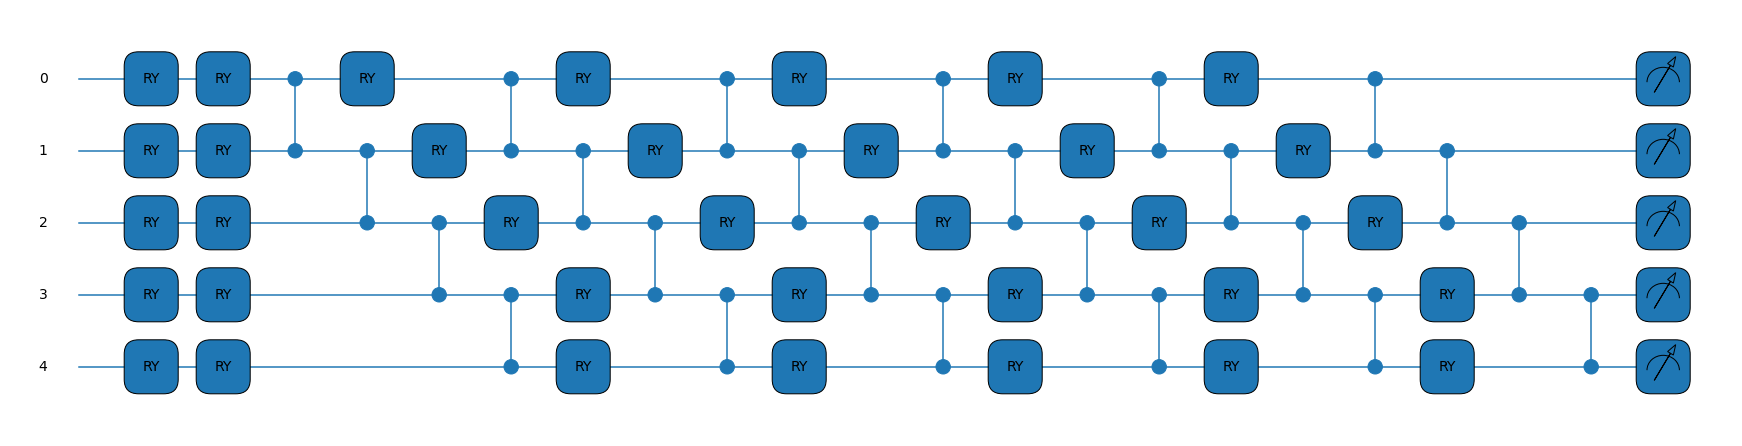

In [13]:
# Showing generator circuit
fig, ax = qml.draw_mpl(quantum_generator_circuit)(noise, gen_weights)
plt.show()

In [14]:
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_generator_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - ancillary_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [15]:
class QuantumGenerator(nn.Module):

    def __init__(self, n_qubits, ancillary_qubits, gen_n_layers, n_generators, q_delta=1):

        self.n_qubits = n_qubits
        self.ancillary_qubits = ancillary_qubits
        self.gen_n_layers = gen_n_layers
        self.n_generators = n_generators

        super().__init__()

        self.q_params = nn.ParameterList([nn.Parameter(q_delta * torch.rand(self.gen_n_layers * self.n_qubits), 
                                          requires_grad=True)for _ in range(self.n_generators)])

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - ancillary_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:

                # Non-linear Transform
                probs = quantum_generator_circuit(elem, params)
                probsgiven0 = probs[: (2 ** (n_qubits - ancillary_qubits))]
                probsgiven0 /= torch.sum(probs)

                # Post-Processing
                q_out = probsgiven0 / torch.max(probsgiven0)
                q_out = q_out.float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

In [16]:
# Testing quantum generator
fixed_noise = torch.rand(1, n_qubits, device=device) * np.pi / 2

generator = QuantumGenerator(n_qubits = n_qubits, ancillary_qubits = ancillary_qubits, 
                                  gen_n_layers = gen_n_layers, n_generators = n_generators).to(device)
test_images = generator(fixed_noise).view(1,1,8,8).cpu().detach()
test_images.shape

torch.Size([1, 64])

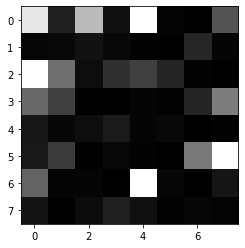

In [17]:
images = torch.squeeze(test_images, dim=1)
for j, im in enumerate(images):
    plt.imshow(im.numpy(), cmap="gray")
    
plt.show()

### Discriminator Network

In [18]:
class Discriminator(nn.Module):

    def __init__(self, image_size):
        super().__init__()

        self.image_size = image_size

        self.model = nn.Sequential(
                                    # Inputs to first hidden layer (num_input_features -> 64)
                                    nn.Linear(self.image_size * self.image_size, 64),
                                    nn.ReLU(),
                                    # First hidden layer (64 -> 16)
                                    nn.Linear(64, 16),
                                    nn.ReLU(),
                                    # Second hidden layer (16 -> output)
                                    nn.Linear(16, 1),
                                    nn.Sigmoid(),
                                    )

    def forward(self, x):
        return self.model(x)

In [19]:
# Testing discriminator network

real_data = rd[0][0]
fake_data = test_images

#disc = Discriminator(image_size)

#outD_real = disc(real_data).view(-1)
#outD_fake = disc(fake_data).view(-1)

### Training class

In [20]:
class QGAN():
    def __init__(self, dataloader, gen_net, disc_net, n_qubits, image_size, batch_size, lrG, lrD, gen_loss, disc_loss):

        self.dataloader = dataloader
        self.gen_net = gen_net
        self.disc_net = disc_net
        self.n_qubits = n_qubits
        self.image_size = image_size
        self.batch_size = batch_size
        self.lrG = lrG
        self.lrD = lrD
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

        # Optimisers
        self.optD = optim.SGD(self.disc_net.parameters(), lr=self.lrD)
        self.optG = optim.SGD(self.gen_net.parameters(), lr=self.lrG)

        self.real_labels = torch.full((self.batch_size,), 1.0, dtype=torch.float, device=device)
        self.fake_labels = torch.full((self.batch_size,), 0.0, dtype=torch.float, device=device)        

               

    def generated_and_save_images(self, results):

        fig = plt.figure(figsize=(20, 10))
        outer = gridspec.GridSpec(5, 2, wspace=0.1)

        for i, images in enumerate(results):
            inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0), subplot_spec=outer[i])
            
            images = torch.squeeze(images, dim=1)
            for j, im in enumerate(images):

                ax = plt.Subplot(fig, inner[j])
                ax.imshow(im.numpy(), cmap="gray")
                ax.set_xticks([])
                ax.set_yticks([])
                if j==0:
                    ax.set_title(f'Iteration {50+i*50}', loc='left', color = 'White')
                fig.add_subplot(ax)

        plt.show()

    def train_step(self, data):

        # Data for training the discriminator
        data = data.reshape(-1, self.image_size * self.image_size)
        real_data = data.to(device)

        # Noise following a uniform distribution in range [0,pi/2)
        noise = torch.rand(self.batch_size, self.n_qubits, device=device) * math.pi / 2
        fake_data = self.gen_net(noise)

        # Training the discriminator
        self.disc_net.zero_grad()
        outD_real = self.disc_net(real_data).view(-1)
        outD_fake = self.disc_net(fake_data.detach()).view(-1)

        errD_real = self.disc_loss(outD_real, self.real_labels)
        errD_fake = self.disc_loss(outD_fake, self.fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        self.optD.step()

        # Training the generator
        self.gen_net.zero_grad()
        outD_fake = self.disc_net(fake_data).view(-1)
        errG = self.gen_loss(outD_fake, self.real_labels)
        errG.backward()
        self.optG.step()

        return errG, errD


    def learn(self, epochs):

        # Fixed noise allows us to visually track the generated images throughout training
        self.fixed_noise = torch.rand(8, self.n_qubits, device=device) * math.pi / 2

        # Iteration counter
        epoch = 0   

        loss_g, loss_d = [], []     

        results = []

        while True:
            for i, (data, _) in enumerate(self.dataloader):

                lg, ld = self.train_step(data)                
                
                epoch += 1

                # Show loss values         
                if epoch % 10 == 0:
                    print(f'Iteration: {epoch}, Generator Loss: {lg:0.3f}, Discriminator Loss: {ld:0.3f}')
                    test_images = self.gen_net(self.fixed_noise).view(8,1,self.image_size,self.image_size).cpu().detach()
                    
                    # Save images every 50 iterations
                    if epoch % 50 == 0:
                        results.append(test_images)  
                        self.generated_and_save_images(results)                  
                
                loss_g.append(lg.detach().numpy())
                loss_d.append(ld.detach().numpy())

                if epoch == epochs:
                    break
            if epoch == epochs:
                break        
    
        plt.plot(np.arange(epochs), loss_g, color = 'Red', label = 'Generator Loss')
        plt.plot(np.arange(epochs), loss_d, color = 'Blue', label = 'Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc = 'upper right')
        plt.show()

In [21]:
n_qubits = 5
ancillary_qubits = 1
gen_n_layers = 6
n_generators = 4
image_size = 8
batch_size = 1
loss = nn.BCELoss()
lrG = 0.3
lrD = 0.01
epochs = 500

Iteration: 10, Generator Loss: 0.680, Discriminator Loss: 1.354
Iteration: 20, Generator Loss: 0.697, Discriminator Loss: 1.328
Iteration: 30, Generator Loss: 0.693, Discriminator Loss: 1.346
Iteration: 40, Generator Loss: 0.674, Discriminator Loss: 1.340
Iteration: 50, Generator Loss: 0.667, Discriminator Loss: 1.343


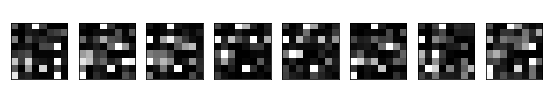

Iteration: 60, Generator Loss: 0.676, Discriminator Loss: 1.323
Iteration: 70, Generator Loss: 0.668, Discriminator Loss: 1.318
Iteration: 80, Generator Loss: 0.653, Discriminator Loss: 1.330
Iteration: 90, Generator Loss: 0.638, Discriminator Loss: 1.325
Iteration: 100, Generator Loss: 0.639, Discriminator Loss: 1.341


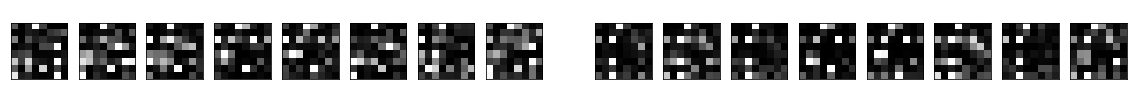

Iteration: 110, Generator Loss: 0.649, Discriminator Loss: 1.263
Iteration: 120, Generator Loss: 0.650, Discriminator Loss: 1.302
Iteration: 130, Generator Loss: 0.683, Discriminator Loss: 1.240
Iteration: 140, Generator Loss: 0.635, Discriminator Loss: 1.254
Iteration: 150, Generator Loss: 0.628, Discriminator Loss: 1.255


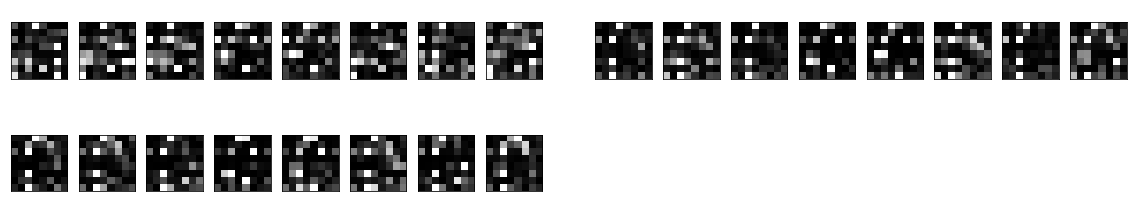

Iteration: 160, Generator Loss: 0.671, Discriminator Loss: 1.184
Iteration: 170, Generator Loss: 0.626, Discriminator Loss: 1.223
Iteration: 180, Generator Loss: 0.657, Discriminator Loss: 1.215
Iteration: 190, Generator Loss: 0.650, Discriminator Loss: 1.238
Iteration: 200, Generator Loss: 0.654, Discriminator Loss: 1.200


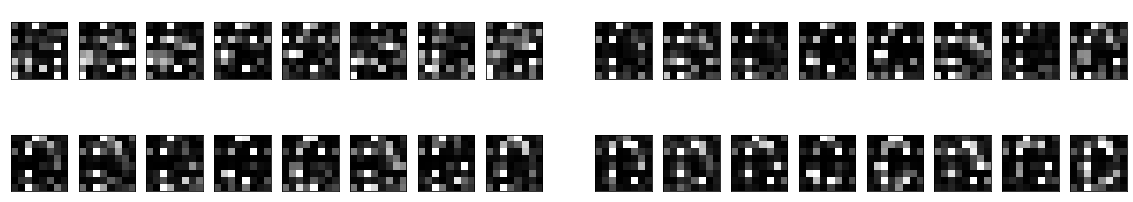

Iteration: 210, Generator Loss: 0.664, Discriminator Loss: 1.224
Iteration: 220, Generator Loss: 0.669, Discriminator Loss: 1.233
Iteration: 230, Generator Loss: 0.574, Discriminator Loss: 1.311
Iteration: 240, Generator Loss: 0.669, Discriminator Loss: 1.169
Iteration: 250, Generator Loss: 0.673, Discriminator Loss: 1.202


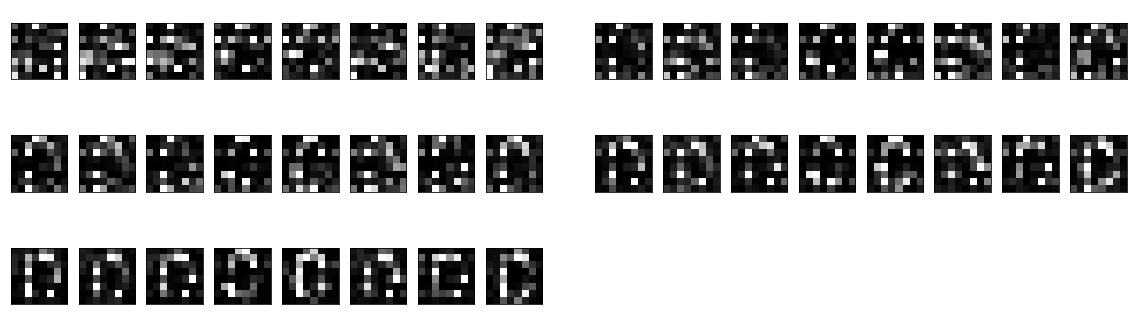

Iteration: 260, Generator Loss: 0.713, Discriminator Loss: 1.143
Iteration: 270, Generator Loss: 0.657, Discriminator Loss: 1.186
Iteration: 280, Generator Loss: 0.714, Discriminator Loss: 1.123
Iteration: 290, Generator Loss: 0.683, Discriminator Loss: 1.249
Iteration: 300, Generator Loss: 0.698, Discriminator Loss: 1.183


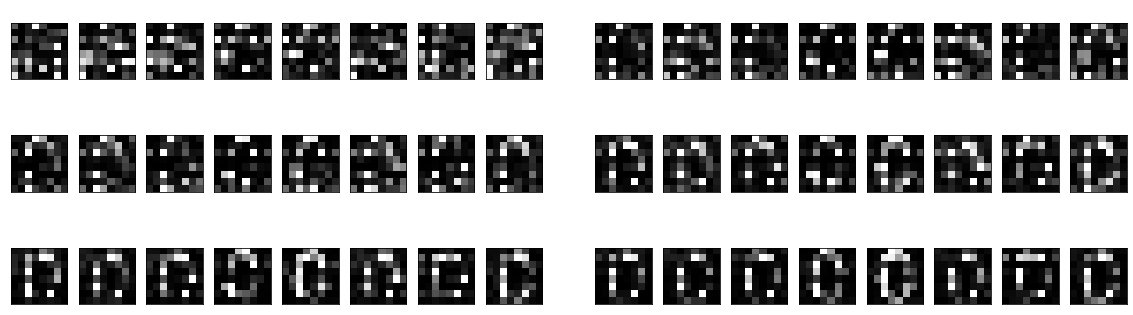

Iteration: 310, Generator Loss: 0.881, Discriminator Loss: 0.954
Iteration: 320, Generator Loss: 0.868, Discriminator Loss: 0.988
Iteration: 330, Generator Loss: 0.723, Discriminator Loss: 1.100
Iteration: 340, Generator Loss: 0.720, Discriminator Loss: 1.132
Iteration: 350, Generator Loss: 0.706, Discriminator Loss: 1.095


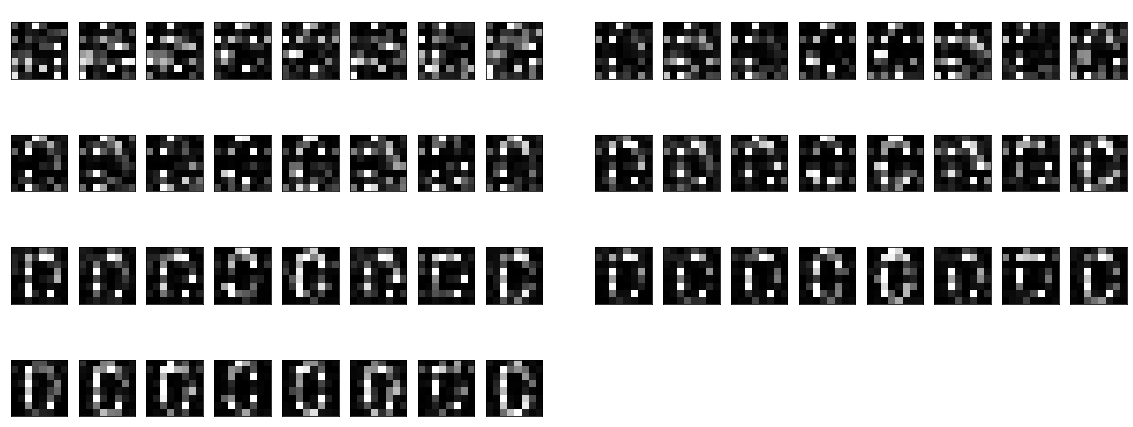

Iteration: 360, Generator Loss: 0.712, Discriminator Loss: 1.035
Iteration: 370, Generator Loss: 0.848, Discriminator Loss: 1.000
Iteration: 380, Generator Loss: 0.877, Discriminator Loss: 0.959
Iteration: 390, Generator Loss: 0.843, Discriminator Loss: 0.982
Iteration: 400, Generator Loss: 0.650, Discriminator Loss: 1.216


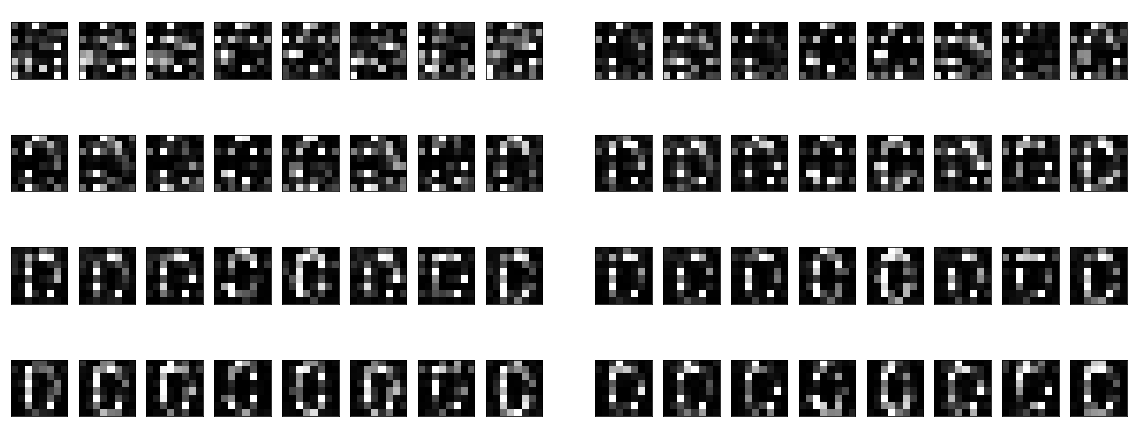

Iteration: 410, Generator Loss: 0.724, Discriminator Loss: 1.104
Iteration: 420, Generator Loss: 0.870, Discriminator Loss: 0.867
Iteration: 430, Generator Loss: 0.640, Discriminator Loss: 1.145
Iteration: 440, Generator Loss: 0.759, Discriminator Loss: 1.023
Iteration: 450, Generator Loss: 0.759, Discriminator Loss: 1.043


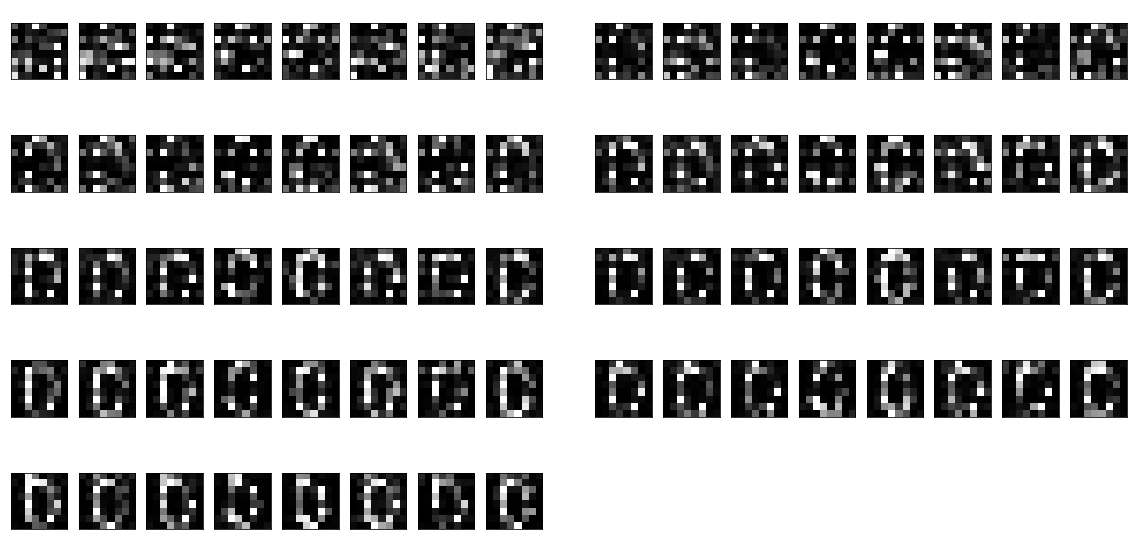

Iteration: 460, Generator Loss: 0.664, Discriminator Loss: 1.100
Iteration: 470, Generator Loss: 0.798, Discriminator Loss: 1.018
Iteration: 480, Generator Loss: 0.952, Discriminator Loss: 0.884
Iteration: 490, Generator Loss: 0.726, Discriminator Loss: 1.072
Iteration: 500, Generator Loss: 1.005, Discriminator Loss: 0.822


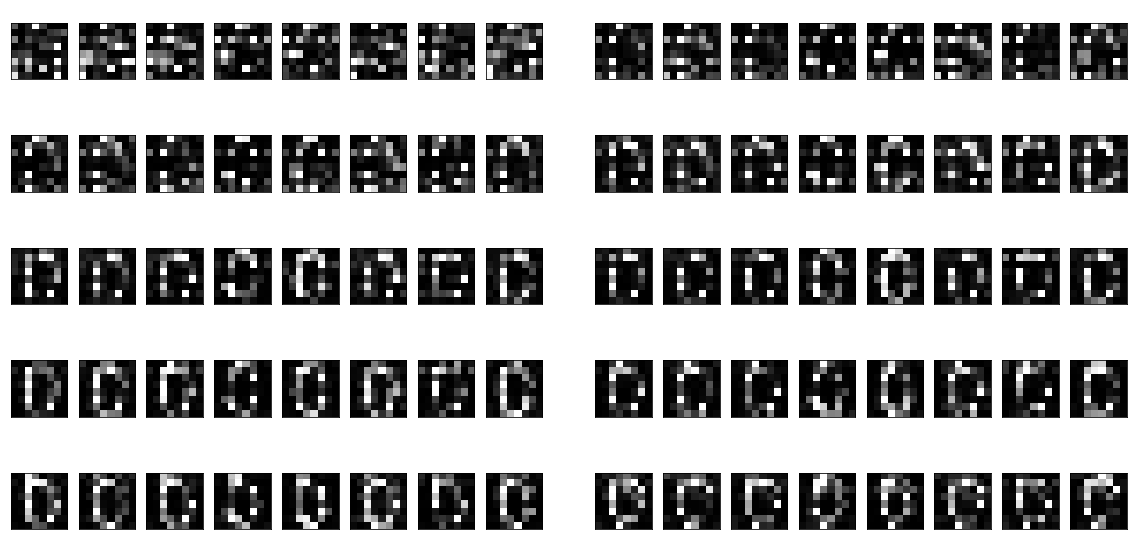

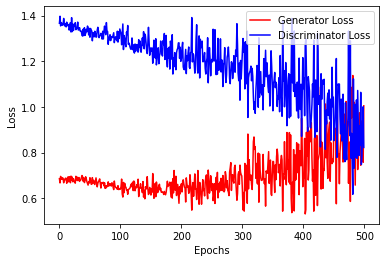

In [22]:
gen_net = QuantumGenerator(n_qubits = n_qubits, ancillary_qubits = ancillary_qubits, 
                           gen_n_layers = gen_n_layers, n_generators = n_generators).to(device)
disc_net = Discriminator(image_size).to(device)

qgan = QGAN(dataloader = dataloader, gen_net = gen_net, disc_net = disc_net, n_qubits = n_qubits, image_size = image_size, 
            batch_size = batch_size, lrG = lrG, lrD = lrD, gen_loss = loss, disc_loss = loss)
qgan.learn(epochs)